In [1]:
import numpy as np
import wisps
import splat
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold,RepeatedKFold, GridSearchCV

import seaborn as sns
import pandas as pd
%matplotlib inline

In [2]:
comb=pd.read_hdf(wisps.COMBINED_PHOTO_SPECTRO_FILE, key='new_stars')

In [3]:
comb=comb.dropna(how='all')

In [4]:
comb=comb.loc[(comb[wisps.INDEX_NAMES]).dropna().index]

In [5]:
comb.shape

(254264, 26)

In [6]:
train_df=pd.read_pickle(wisps.LIBRARIES+'/training_set.pkl').reset_index(drop=True)
                                                                           
pred_df=wisps.Annotator.reformat_table(comb).reset_index(drop=True)

In [7]:
pred_df=pred_df.drop_duplicates(subset='grism_id')

In [8]:
pred_df.shape, train_df.shape

((254264, 26), (9728, 26))

In [9]:
def apply_scale(x):
    ##put features on a log scale
    #replace nans
    y=np.log10(x)
    if np.isnan(y) or np.isinf(y):
        y=np.random.uniform(-99, -98)
    return y

def create_labels(row):
    #use multiclass system
    label=0
    if row.label ==0.:
        label=0
    if (row.label==1) & (row.spt <20):
        label=1
    if (row.label==1) & np.logical_and(row.spt >=20, row.spt<30):
        label=2
    if (row.label==1) & np.logical_and(row.spt >=30, row.spt<45):
        label=3
    return label

In [10]:

pred_df['grism_id']=pred_df.grism_id.apply(lambda x: x.lower())

In [11]:
#features=wisps.INDEX_NAMES
features=np.concatenate([['snr2','f_test', 'line_chi', 'spex_chi'], wisps.INDEX_NAMES])
#features=['snr2','snr1', 'snr3', 'snr4', 'f_test']

In [12]:
pred_df=pred_df[pred_df.snr2>3.]
train_df['spt']=train_df.spt.apply(wisps.make_spt_number)
pred_df['spt']=pred_df.spt.apply(wisps.make_spt_number)

In [13]:
labels=train_df.apply(create_labels, axis=1).values

In [14]:
train_df[features]=(train_df[features]).applymap(apply_scale)
pred_df[features]=(pred_df[features]).applymap(apply_scale)

In [15]:
scaler = MinMaxScaler(feature_range=(-100, 100))
scaler.fit(train_df[features])
X=scaler.transform(train_df[features])
y=labels

In [16]:
#scale the data set to predict for the prediction set
pred_set=scaler.transform(pred_df[features])

In [17]:
class_weigths={0:1., 1:40/10000, 2:1/10000, 3:5/10000}

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,  random_state=np.random.randint(1000))

In [19]:
np.linspace(10, 1000, 10, dtype=int)

array([  10,  120,  230,  340,  450,  560,  670,  780,  890, 1000])

In [20]:
import dask

In [21]:
from dask.distributed import Client, progress
client = Client(processes=False, threads_per_worker=4,
                n_workers=1, memory_limit='2GB',  silence_logs='error')
client

Client Scheduler: inproc://192.168.0.2/38684/1 Dashboard: http://192.168.0.2:8787/status,Cluster Workers: 1 Cores: 4 Memory: 2.00 GB


In [22]:
import warnings
warnings.filterwarnings('ignore')


In [23]:

np.linspace(2, 10, 10, dtype=int)

array([ 2,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [28]:
#do some grid search, use dask to make it faster?
parameters = {'n_estimators': np.linspace(10, 1000, 10, dtype=int),
              'min_samples_split': np.linspace(1, 10, 10, dtype=int)}
#random forest
mrf= RandomForestClassifier()

#initialize grid search object

clf = GridSearchCV(mrf, parameters, refit=False, verbose=2, scoring='precision_macro')
#fit the training data
clf.fit(X, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] min_samples_split=1, n_estimators=10 ............................
[CV] ............. min_samples_split=1, n_estimators=10, total=   0.0s
[CV] min_samples_split=1, n_estimators=10 ............................
[CV] ............. min_samples_split=1, n_estimators=10, total=   0.0s
[CV] min_samples_split=1, n_estimators=10 ............................
[CV] ............. min_samples_split=1, n_estimators=10, total=   0.0s
[CV] min_samples_split=1, n_estimators=10 ............................
[CV] ............. min_samples_split=1, n_estimators=10, total=   0.0s
[CV] min_samples_split=1, n_estimators=10 ............................
[CV] ............. min_samples_split=1, n_estimators=10, total=   0.0s
[CV] min_samples_split=1, n_estimators=120 ...........................
[CV] ............ min_samples_split=1, n_estimators=120, total=   0.1s
[CV] min_samples_split=1, n_estimators=120 ...........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ............ min_samples_split=1, n_estimators=120, total=   0.1s
[CV] min_samples_split=1, n_estimators=120 ...........................
[CV] ............ min_samples_split=1, n_estimators=120, total=   0.1s
[CV] min_samples_split=1, n_estimators=120 ...........................
[CV] ............ min_samples_split=1, n_estimators=120, total=   0.1s
[CV] min_samples_split=1, n_estimators=120 ...........................
[CV] ............ min_samples_split=1, n_estimators=120, total=   0.1s
[CV] min_samples_split=1, n_estimators=230 ...........................
[CV] ............ min_samples_split=1, n_estimators=230, total=   0.1s
[CV] min_samples_split=1, n_estimators=230 ...........................
[CV] ............ min_samples_split=1, n_estimators=230, total=   0.1s
[CV] min_samples_split=1, n_estimators=230 ...........................
[CV] ............ min_samples_split=1, n_estimators=230, total=   0.1s
[CV] min_samples_split=1, n_estimators=230 ...........................
[CV] .

distributed.client - ERROR - Error in callback <function DaskDistributedBackend.apply_async.<locals>.callback_wrapper at 0x1a5032c440> of <Future: cancelled, type: builtins.list, key: _parallel_build_trees-batch-969183dc7713416f87a0398f1b2a8ef5>:
Traceback (most recent call last):
  File "/Users/caganze/anaconda3/lib/python3.7/site-packages/distributed/client.py", line 285, in execute_callback
    fn(fut)
  File "/Users/caganze/anaconda3/lib/python3.7/site-packages/joblib/_dask.py", line 260, in callback_wrapper
    result = future.result()
  File "/Users/caganze/anaconda3/lib/python3.7/site-packages/distributed/client.py", line 222, in result
    raise result
concurrent.futures._base.CancelledError: _parallel_build_trees-batch-969183dc7713416f87a0398f1b2a8ef5
distributed.client - ERROR - Error in callback <function DaskDistributedBackend.apply_async.<locals>.callback_wrapper at 0x1b0ec71440> of <Future: cancelled, key: _parallel_build_trees-batch-889faa4206c64b38be3f976b1936b462>:
Tra

[CV] ............ min_samples_split=2, n_estimators=120, total=   8.2s
[CV] min_samples_split=2, n_estimators=120 ...........................
[CV] ............ min_samples_split=2, n_estimators=120, total=   3.0s
[CV] min_samples_split=2, n_estimators=230 ...........................
[CV] ............ min_samples_split=2, n_estimators=230, total=   8.9s
[CV] min_samples_split=2, n_estimators=230 ...........................
[CV] ............ min_samples_split=2, n_estimators=230, total=   6.5s
[CV] min_samples_split=2, n_estimators=230 ...........................
[CV] ............ min_samples_split=2, n_estimators=230, total=   6.5s
[CV] min_samples_split=2, n_estimators=230 ...........................
[CV] ............ min_samples_split=2, n_estimators=230, total=   5.8s
[CV] min_samples_split=2, n_estimators=230 ...........................
[CV] ............ min_samples_split=2, n_estimators=230, total=   4.2s
[CV] min_samples_split=2, n_estimators=340 ...........................
[CV] .

distributed.client - ERROR - Error in callback <function DaskDistributedBackend.apply_async.<locals>.callback_wrapper at 0x1b1127ce60> of <Future: finished, type: builtins.list, key: _parallel_build_trees-batch-218da332986f4017aa21386a4f7b15bc>:
Traceback (most recent call last):
  File "/Users/caganze/anaconda3/lib/python3.7/site-packages/distributed/client.py", line 285, in execute_callback
    fn(fut)
  File "/Users/caganze/anaconda3/lib/python3.7/site-packages/joblib/_dask.py", line 260, in callback_wrapper
    result = future.result()
  File "/Users/caganze/anaconda3/lib/python3.7/site-packages/distributed/client.py", line 217, in result
    result = self.client.sync(self._result, callback_timeout=timeout, raiseit=False)
  File "/Users/caganze/anaconda3/lib/python3.7/site-packages/distributed/client.py", line 780, in sync
    self.loop, func, *args, callback_timeout=callback_timeout, **kwargs
  File "/Users/caganze/anaconda3/lib/python3.7/site-packages/distributed/utils.py", line 

[CV] ............ min_samples_split=2, n_estimators=890, total=  40.0s
[CV] min_samples_split=2, n_estimators=890 ...........................
[CV] ............ min_samples_split=2, n_estimators=890, total=  30.4s
[CV] min_samples_split=2, n_estimators=890 ...........................
[CV] ............ min_samples_split=2, n_estimators=890, total=  27.4s
[CV] min_samples_split=2, n_estimators=890 ...........................
[CV] ............ min_samples_split=2, n_estimators=890, total=  22.7s
[CV] min_samples_split=2, n_estimators=890 ...........................
[CV] ............ min_samples_split=2, n_estimators=890, total=  26.3s
[CV] min_samples_split=2, n_estimators=1000 ..........................
[CV] ........... min_samples_split=2, n_estimators=1000, total=  24.1s
[CV] min_samples_split=2, n_estimators=1000 ..........................
[CV] ........... min_samples_split=2, n_estimators=1000, total=  24.9s
[CV] min_samples_split=2, n_estimators=1000 ..........................
[CV] .

distributed.client - ERROR - Error in callback <function DaskDistributedBackend.apply_async.<locals>.callback_wrapper at 0x1b409e07a0> of <Future: finished, type: builtins.list, key: _parallel_build_trees-batch-7b87c5eb72c943eda410cb6f4e4b7ea0>:
Traceback (most recent call last):
  File "/Users/caganze/anaconda3/lib/python3.7/site-packages/distributed/client.py", line 285, in execute_callback
    fn(fut)
  File "/Users/caganze/anaconda3/lib/python3.7/site-packages/joblib/_dask.py", line 260, in callback_wrapper
    result = future.result()
  File "/Users/caganze/anaconda3/lib/python3.7/site-packages/distributed/client.py", line 217, in result
    result = self.client.sync(self._result, callback_timeout=timeout, raiseit=False)
  File "/Users/caganze/anaconda3/lib/python3.7/site-packages/distributed/client.py", line 780, in sync
    self.loop, func, *args, callback_timeout=callback_timeout, **kwargs
  File "/Users/caganze/anaconda3/lib/python3.7/site-packages/distributed/utils.py", line 

[CV] ............ min_samples_split=5, n_estimators=670, total=40.8min
[CV] ............ min_samples_split=5, n_estimators=670, total=40.5min


distributed.client - ERROR - Error in callback <function DaskDistributedBackend.apply_async.<locals>.callback_wrapper at 0x1b10c5f5f0> of <Future: cancelled, type: builtins.list, key: _parallel_build_trees-batch-0eecfb4a6331457ca7fedc777e3fac25>:
Traceback (most recent call last):
  File "/Users/caganze/anaconda3/lib/python3.7/site-packages/distributed/client.py", line 285, in execute_callback
    fn(fut)
  File "/Users/caganze/anaconda3/lib/python3.7/site-packages/joblib/_dask.py", line 260, in callback_wrapper
    result = future.result()
  File "/Users/caganze/anaconda3/lib/python3.7/site-packages/distributed/client.py", line 222, in result
    raise result
concurrent.futures._base.CancelledError: _parallel_build_trees-batch-0eecfb4a6331457ca7fedc777e3fac25
distributed.client - ERROR - Error in callback <function DaskDistributedBackend.apply_async.<locals>.callback_wrapper at 0x1a3f583c20> of <Future: cancelled, type: builtins.list, key: _parallel_build_trees-batch-eaef3112704a4fdba

[CV] ............ min_samples_split=3, n_estimators=560, total=  18.3s
[CV] min_samples_split=3, n_estimators=560 ...........................
[CV] ............ min_samples_split=5, n_estimators=780, total=40.3min
[CV] ............ min_samples_split=5, n_estimators=780, total=40.1min
[CV] ............ min_samples_split=3, n_estimators=560, total=  38.3s
[CV] min_samples_split=3, n_estimators=560 ...........................
[CV] ............ min_samples_split=3, n_estimators=560, total=  17.8s
[CV] min_samples_split=3, n_estimators=560 ...........................
[CV] ............ min_samples_split=3, n_estimators=560, total=  15.8s
[CV] min_samples_split=3, n_estimators=560 ...........................
[CV] ............ min_samples_split=3, n_estimators=560, total=  12.6s
[CV] min_samples_split=3, n_estimators=670 ...........................
[CV] ............ min_samples_split=3, n_estimators=670, total=  19.8s
[CV] min_samples_split=3, n_estimators=670 ...........................
[CV] .

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 91.1min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [33]:
ressc=pd.DataFrame(clf.cv_results_)

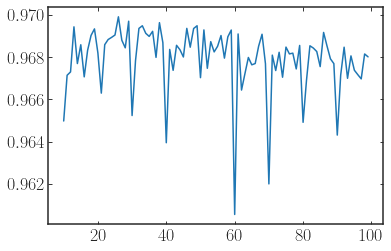

In [34]:
plt.plot(ressc['mean_test_score'])

In [35]:
clf.best_score_, clf.best_params_

(0.9699100581040024, {'min_samples_split': 3, 'n_estimators': 670})

In [75]:
rf = RandomForestClassifier(n_estimators=670, min_samples_split=3, verbose=True,bootstrap=True, n_jobs=-1, 
                            class_weight=class_weigths, criterion='entropy',  random_state=np.random.randint(1000), 
                            warm_start=False)
rf.fit(X_train, y_train)
pred_labels = rf.predict(X_test)
model_accuracy = accuracy_score(y_test, pred_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 670 out of 670 | elapsed:    3.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 670 out of 670 | elapsed:    0.3s finished


In [76]:
print ('accuracy score {}'.format(model_accuracy))
classes=['non-UCD', 'M7-L0', 'L', 'T']
cm = pd.DataFrame(confusion_matrix(y_test, pred_labels), 
                  columns=classes, index=classes)


accuracy score 0.9769736842105263


In [77]:
precision_score(y_test, pred_labels, average='macro')

0.9647710976400707

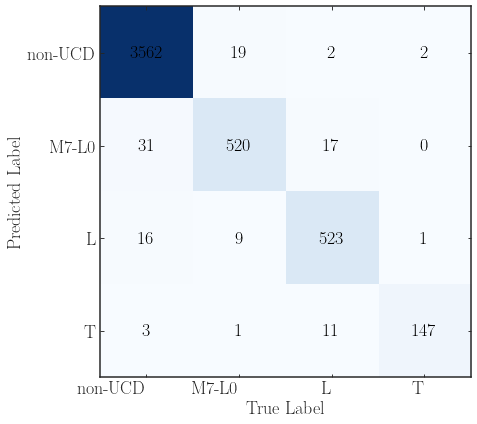

In [78]:
#create a table a confusion matrix

fig, ax=plt.subplots(figsize=(8, 6))

#matr=(cm/cm.sum()).applymap(lambda x: np.round(x, 2)).values
matr=cm.values
im = ax.imshow(matr, cmap='Blues')

# We want to show all ticks...
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
# ... and label them with the respective list entries
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

ax.set_xlabel('True Label', fontsize=18)
ax.set_ylabel('Predicted Label', fontsize=18)
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(classes)):
    for j in range(len(classes)):
        text = ax.text(j, i, matr[i, j], ha="center", va="center", color="k", fontsize=18)
        
ax.set_xlim([-0.5, 3.5])
ax.set_ylim([3.5, -0.5])
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/confusion_matrix.pdf')

In [79]:
rlabels=rf.predict(pred_set)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 670 out of 670 | elapsed:    2.1s finished


In [80]:
len(rlabels[rlabels>0])

168

In [42]:
cands=pd.read_pickle(wisps.OUTPUT_FILES+'/true_spectra_cands.pkl')

In [43]:
cands['grism_id']=cands.grism_id.apply(lambda x: x.lower())
cands['spt']=[x.spectral_type for x in cands.spectra]

In [44]:
len(cands), len( pred_df[pred_df.grism_id.isin(cands.grism_id.values)])

(364, 362)

In [45]:
strs=wisps.datasets['stars']

In [46]:
#cands[~ cands.grism_id.isin(pred_df.grism_id.values) ]

In [47]:
cands[~ cands.grism_id.isin(strs.grism_id.values) ]

,grism_id,spectra,spt,spt_unc,distance,RA,DEC,snr1,pointing,designation


In [48]:
true=(pred_df[(rlabels>0) & pred_df.grism_id.isin(cands.grism_id.values)])#.drop_duplicates(subset='grism_id')
truep=len(true)
ps=len(rlabels[rlabels>0])

In [49]:
len(true[true.spt.between(17,19)]), len(true[true.spt.between(20,29)]), len(true[true.spt.between(30,40)])

(40, 11, 5)

In [50]:
'FP rate {}'.format((ps-truep)/ps)

'FP rate 0.42011834319526625'

In [51]:
rf_dict={'classifier': rf,
            'sclr':scaler,
            'feats':features}

In [52]:
import pickle

In [53]:
#save the random forest
output_file=wisps.OUTPUT_FILES+'/random_forest_classifier.pkl'
with open(output_file, 'wb') as file:
    pickle.dump(rf_dict,file)

In [54]:
sv_df=pred_df[(rlabels>0)]

In [55]:
sv_df.to_pickle(wisps.LIBRARIES+'/labelled_by_rf.pkl')

In [56]:
slbyids=pd.read_pickle(wisps.OUTPUT_FILES+'/selected_by_indices.pkl')

In [57]:
#slbyids

In [58]:
len(sv_df[(sv_df.grism_id.isin(slbyids.grism_id)) & (sv_df.grism_id.isin(cands.grism_id))])

23

In [59]:
len(sv_df[( ~sv_df.grism_id.isin(slbyids.grism_id)) & (sv_df.grism_id.isin(cands.grism_id))])

75

In [60]:
len(slbyids[( ~slbyids.grism_id.isin(sv_df.grism_id)) & (slbyids.grism_id.isin(cands.grism_id))])

58

In [61]:
pred_df.shape

(67450, 26)

In [62]:
not_in=cands[~cands.grism_id.isin(comb.grism_id)]

In [63]:
(not_in[['spt', 'grism_id']]).values

array([[array([16.,  1.]), 'goodsn-36-g141_24221'],
       [array([17.,  0.]), 'goodsn-36-g141_22694']], dtype=object)

In [64]:
s=wisps.Source(filename='goodss-04-G141_17402', is_ucd=True)

In [65]:
#low=pd.read_pickle(wisps.LIBRARIES+'/lowsnr_obejcts.pkl')

In [66]:
#high=pd.read_pickle(wisps.LIBRARIES+'/highsnr_obejcts.pkl')

In [67]:
#comb=pd.concat([low, high], ignore_index=True)

In [68]:
#comb['grism_id']=comb.grism_id.apply(lambda x: str(x).lower())

In [69]:
#comb.to_hdf(wisps.COMBINED_PHOTO_SPECTRO_FILE, key='new_stars')

In [70]:
#comb.loc[578]

In [71]:
comb.shape

(254264, 26)

In [82]:
s=wisps.Source(filename='goodss-28-G141_14876')

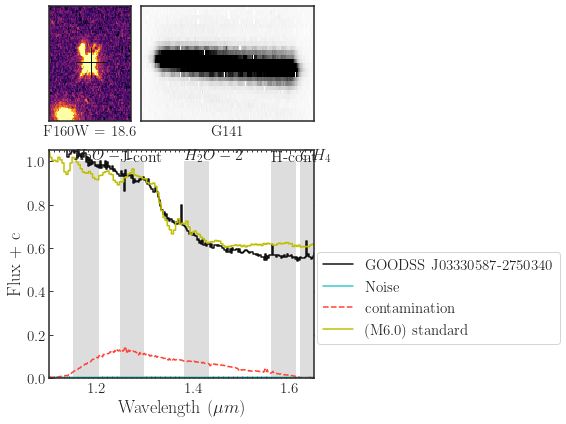

In [83]:
s.plot()

In [142]:
files=glob.glob('/users/caganze/desktop/ATMO_2020_models/evolutionary_tracks/ATMO_CEQ/MKO_WISE_IRAC/*')

In [143]:
dframes=[]

In [144]:
for f in tqdm(files):
    dframes.append(ascii.read(f).to_pandas())
    

100%|██████████| 76/76 [00:00<00:00, 83.94it/s]


In [145]:
df=pd.concat(dframes).rename(columns='Teff')

In [147]:
df.columns=[x.lower() for x in df.columns]

In [149]:
df=df.rename(columns={'teff':'temperature'})

In [150]:
df.to_csv('/users/caganze/research/wisps/evmodels/phillips2020.csv')